<img src=../images/NCAR-contemp-logo-blue.png width=500px alt="NCAR Logo">

# Dask on HPC - Starting Clusters, Monitoring, and Debugging

**ESDS Dask Tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)
---------

### In this tutorial, you will learn:

* How to configure and initialize an HPC Dask cluster via `dask-jobqueue`
* How to manage and monitor the resource usage of your Dask workers
* Understanding Dask worker logs
* Controlling how and where data spills from memory to disk
* Analyzing the impact of your Dask workflow on your allocation

**Related Documentation**

????

---

## Starting HPC Dask clusters with `dask-jobqueue`

A defining feature of most HPC systems is the batch scheduler - *Slurm, PBS, LSF, etc...* These schedulers allow us to access the significant resources of the system and scale far beyond what is capable by a personal workstation.

Using Dask on an HPC system is no different - we need to interact with the scheduler to provide Dask with ample compute resources. We *could* first start a job with multiple cores and a large amount of memory, and then use the **LocalCluster** to spawn workers. However, this approach only scales to a single node.

The typical approach is to let Dask request resources directly from the job scheduler via a scheduler-specific cluster type. Such clusters are provided by the add-on `dask-joqueue` package.

### Creating a scheduled-cluster

Since we use the PBS Pro scheduler at NCAR, we will use the **PBSCluster** Dask scheduler from `dask-joqueue`. Initialization is similar to a **LocalCluster**, but with unique parameters specific to creating batch jobs.

In [1]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

The parameters of the `PBSCluster` provide a basic template for the resources that will be assigned to each job...

In [2]:
# Create a PBS cluster object
cluster = PBSCluster(
     cores=1,
     memory='2GiB',
     processes=1,
     local_directory='/local_scratch/pbs.$PBS_JOBID/dask/spill',
     resource_spec='select=1:ncpus=1:mem=2GB',
     queue='casper',
     walltime='30:00',
     interface='ib0'
)

We should pause and consider some of these settings...
* Here we are assigning a single worker to each job. This is a reasonable default and yields highest job throughput, but other configurations are possible.
* The `cores` and `memory` parameters are used by Dask to define workers, while the `resource_spec` is used by PBS to define jobs. In this single-worker config, they should match!
* PBS uses *GB* to mean 1024-based storage units. `dask-jobqueue` accurately calls these `GiB`.
* We use `interface='ib0'` to instruct Dask to use TCP over Infiniband (the high-speed network on Casper), instead of the slower ethernet network.

**It is good practice to check your validate your cluster before initiating any workers, by outputting the job script Dask will create**

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A SCSG0001
#PBS -l select=1:ncpus=1:mem=2GB
#PBS -l walltime=30:00
#PBS -e dask-worker-logs/
#PBS -o dask-worker-logs/
#PBS -j oe

/glade/u/apps/opt/conda/envs/npl-2023a/bin/python -m distributed.cli.dask_worker tcp://10.12.206.47:45140 --nthreads 1 --memory-limit 2.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ib0



*Note how some settings are showing up despite me not setting them... where does my account come from, for example?*

Let's take a detour for a moment...

### Dask configuration files

We can customize the behavior of Dask using YAML-based configuration files. These have some advantages:

* Eliminate user-specific configuration from your notebooks/scripts
* Avoid repetition in defining clusters and other Dask objects
* Potentially reduce errors from forgetting important settings

And also some downsides:

* Obfuscates settings from others (including your future self!)
* Reduces portability and ease of debugging

User configuration files are stored in `~/.config/dask` by default. System administrators may also provide default Dask configuration in `/etc/dask` or via the `DASK_ROOT_CONFIG` environment variable.

In [4]:
!ls ~/.config/dask

jobqueue.yaml  labextension.yaml


In [5]:
# Programmatically view configuration file(s) within Python
from dask import config
config.refresh()
config.get('jobqueue.pbs')

{'name': 'dask-worker',
 'cores': 1,
 'memory': '2GiB',
 'processes': 1,
 'interface': 'ib0',
 'death-timeout': 60,
 'local-directory': '/local_scratch/pbs.$PBS_JOBID/dask',
 'shared-temp-directory': None,
 'extra': None,
 'worker-extra-args': [],
 'shebang': '#!/usr/bin/env bash',
 'queue': 'casper',
 'account': 'SCSG0001',
 'walltime': '00:30:00',
 'env-extra': None,
 'job-script-prologue': [],
 'resource-spec': '-l select=1:ncpus=1:mem=2GB',
 'job-extra': None,
 'job-extra-directives': ['-j oe'],
 'job-directives-skip': [],
 'log-directory': 'dask-worker-logs',
 'scheduler-options': {}}

### Live Performance Monitoring

Using `dask.distributed` provides us with a powerful diagnostic tool you have already seen: the *Dashboard*. The Dashboard can be integrated into your Jupyter environment in two ways - either with a separate website accessible from the Client widgit, or as tabs in your JupyterLab interface via the `dask-labextension` add-on.

Let's see how both can be used to monitor Dask workers.

In [6]:
# Create the client to load the Dashboard
client = Client(cluster)

In [7]:
# Display the client repr
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/Casper/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/Casper/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.47:45140,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/Casper/proxy/8787/status,Total threads: 0
Started: 9 minutes ago,Total memory: 0 B


The Dashboard is immediately accessible above when using NCAR's JupyterHub. This URL can also be entered into the Dashboard extension (click the Dask logo on the left toolbar), which allows you to add useful screens like `Task Stream` and `Workers Memory` to your Lab interface.

In [18]:
# Scale the cluster to 2 workers (which will use 2 jobs here)
cluster.scale(2)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(2)

In [9]:
# See the workers from the cluster object
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>}

In [10]:
# See the workers in the job scheduler
!qstat -u $USER


casper-pbs: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
5497026.casper* vanderwb jhublog* cr-login-*   9762   1   1    4gb 720:0 R 01:24
5497479.casper* vanderwb htc      dask-work* 232504   1   1    2gb 00:30 R 00:00
5497480.casper* vanderwb htc      dask-work* 232553   1   1    2gb 00:30 R 00:00


*As soon as we scale the cluster up, the clock is ticking on these PBS jobs. Be mindful of idle workers when using a batch scheduler!*

#### Dashboard demo: multi-file Xarray data analysis

To demonstrate how the Dashboard can be useful, let's do some simply analysis of data files using Xarray. Here we load 8 days of GOES5 data, and compute the mean near-surface temperature across the western US.

In [11]:
import xarray as xr

In [19]:
# Use a multi-file import and load data in parallel
ds = xr.open_mfdataset("/glade/collections/rda/data/ds313.0/orig_res/2022/GEOS5_orig_res_202201[0-1]*.nc", parallel = True)

In [20]:
# Show the total size of the variable (this has not been read in yet!)
print("Size of Variable = {:5.2f} GiB".format(ds.T.nbytes / 1024 ** 3))

Size of Variable = 33.86 GiB


This data is much too big for our worker template, but as we have seen the chunks will be smaller in size. We can see if they will fit in RAM or cause spill by querying the data array

In [21]:
# The graphical repr of one DaskArray - T
ds.T

<xarray.DataArray 'T' (time: 152, lev: 72, lat: 721, lon: 1152)>
dask.array<concatenate, shape=(152, 72, 721, 1152), dtype=float32, chunksize=(8, 72, 721, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-19T21:00:00
  * lev      (lev) float32 0.015 0.02635 0.04014 0.05679 ... 962.5 977.5 992.5
Attributes:
    long_name:       air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    standard_name:   air_temperature
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

It looks like our data will fit into RAM, but we can verify using the Dashboard. Let's construct our computation. Here we do the following:
1. Subset the "western US" from the data via lat/lon slices
2. Take the mean of temperature values across our western US box
3. Select the near-surface level (0)

Remember, we are just creating the task graph here. No work will occur yet in our cluster.

In [22]:
# Create our task graph
sfc_mean_graph = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).isel(lev = 0)

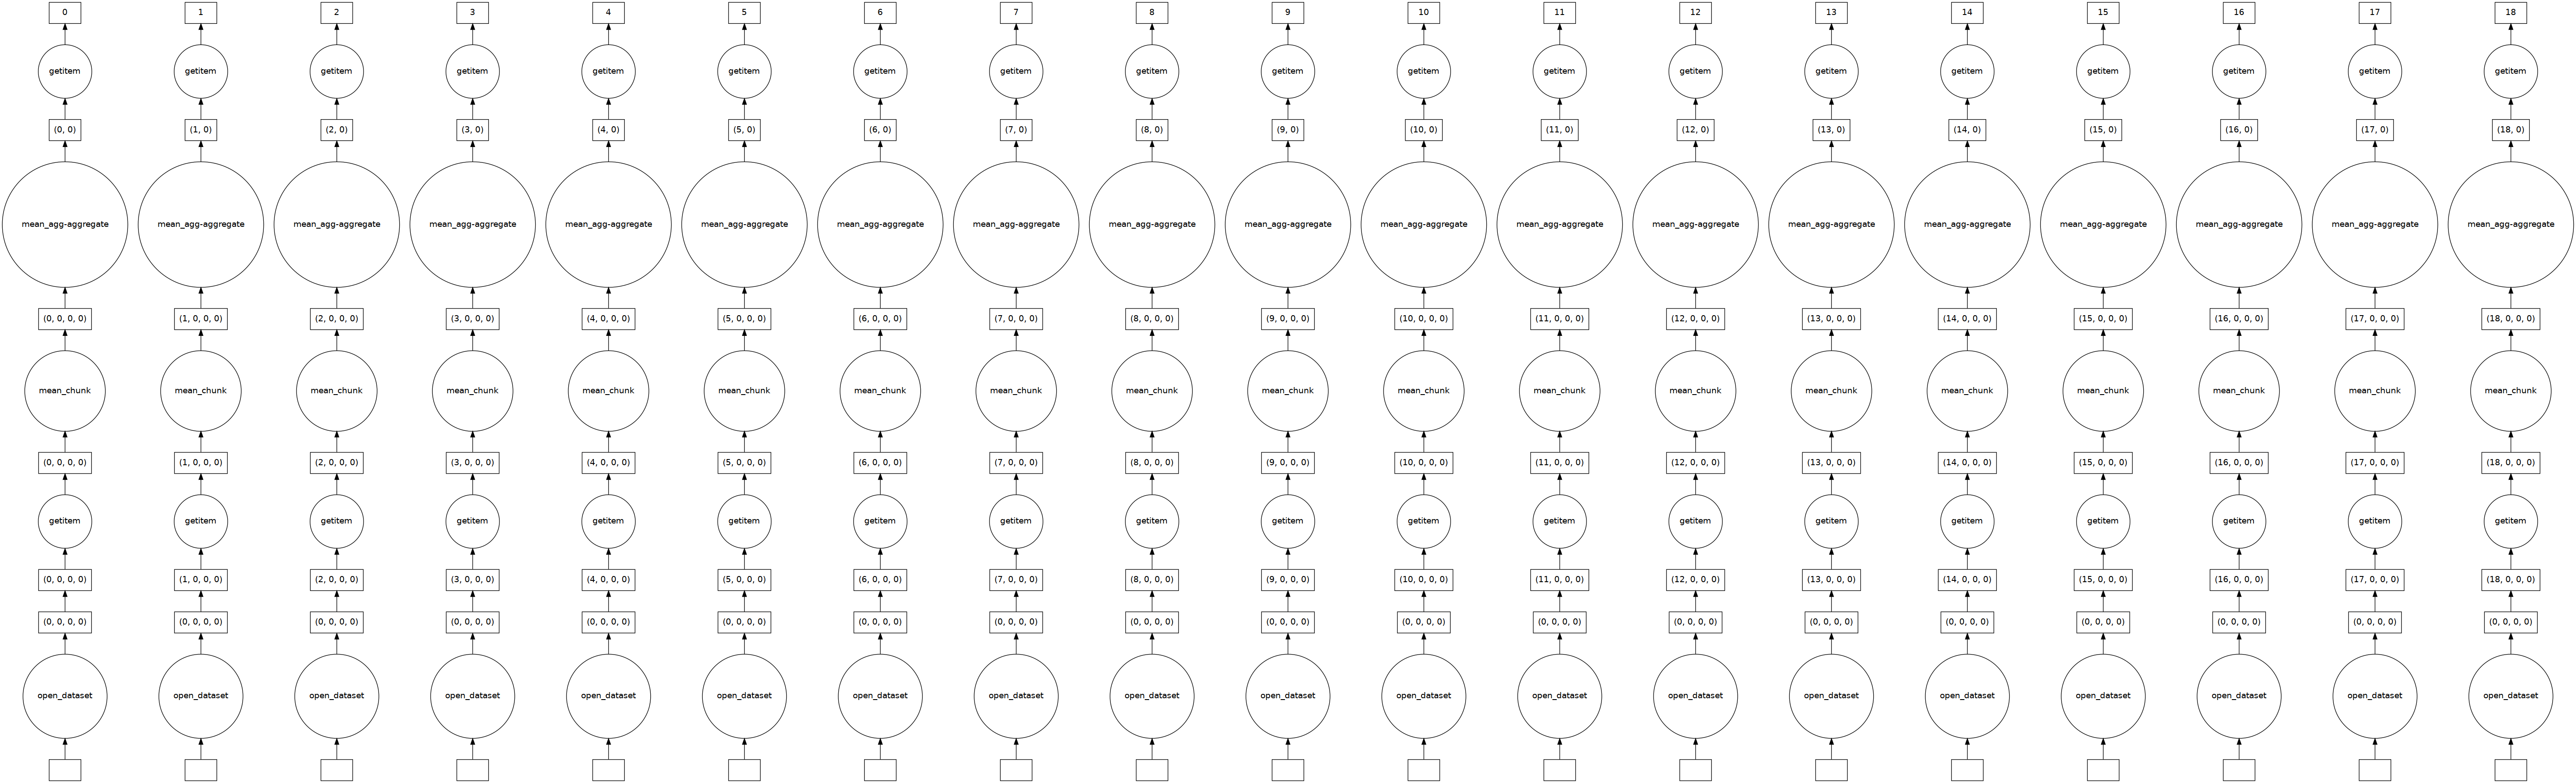

In [23]:
# Tip - double-click the figure to see the actual size
dask.visualize(sfc_mean_graph)

Now, we can use `.compute()` to start the computation on our cluster. Keep an eye on the dashboard plots to follow progress.

In [24]:
%%time
result = sfc_mean_graph.compute()

CPU times: user 1.05 s, sys: 100 ms, total: 1.15 s
Wall time: 32.8 s


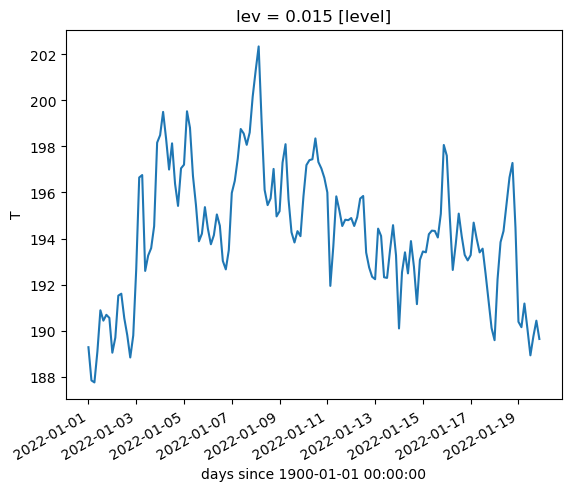

In [25]:
result.plot()

Now, let's see what speedup we can get by manually scaling up our computation by 2x. This is not possible (*beyond a certain hardware limit*) on a `LocalCluster`, but is easy to do using `dask-jobqueue`!

In [26]:
# Scale the cluster to 4 workers
cluster.scale(4)
client.wait_for_workers(4)

In [27]:
# How does this look in PBS?
!qstat -u vanderwb


casper-pbs: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
5497026.casper* vanderwb jhublog* cr-login-*   9762   1   1    4gb 720:0 R 02:49
5498724.casper* vanderwb htc      dask-work* 265498   1   1    2gb 00:30 R 00:02
5498725.casper* vanderwb htc      dask-work* 265647   1   1    2gb 00:30 R 00:02
5498731.casper* vanderwb htc      dask-work* 259317   1   1    2gb 00:30 R 00:00
5498732.casper* vanderwb htc      dask-work* 259457   1   1    2gb 00:30 R 00:00


One downside of scaling (be it manual or adaptive), is that you end up with a worker pool that has different amounts of wallclock time remaining. The flow of your script across time is something to consider - if you need to spin up more workers after some collection of them has used significant walltime, it may make sense to first scale down your cluster to zero (or run `client.restart()`) and then instantiate the new workers.

Here, we will also demonstrate another type of performance monitoring provided by `dask.distributed` - the *performance report*. Using a context manager, we can profile memory, disk, CPU, network usage and the task stream and store it as an HTML file for future analysis. Think of it as a hard-copy of the dashboard.

In [28]:
# Let's try generating a "performance report" this time
from dask.distributed import performance_report

In [29]:
%%time
# Since metrics are captured live anyway, the overhead from the report is small
with performance_report(filename="dask-pr.html"):
    result = sfc_mean_graph.compute()

CPU times: user 970 ms, sys: 57.7 ms, total: 1.03 s
Wall time: 16.8 s


One improvement we can make to our computation is to reduce the size of the problem down as much as possible before doing meaningful work. Let's try rearranging our graph:

In [30]:
# Create our improved task graph
sfc_mean_graph = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).isel(lev = 0).mean(["lat","lon"])

In [31]:
%%time
result = sfc_mean_graph.compute()

CPU times: user 210 ms, sys: 17.6 ms, total: 227 ms
Wall time: 4.37 s


Since flattening the level dimension will reduce data compared to the lat-lon box, let's do that first to make subsequent operations cheaper.

|Indexing|Dimensions|Pts Eliminated|
|-|-|-|
|isel|721 x 1152 x 71|58,972,032|
|sel|(721 - 81) x (1152 - 81) x 72|49,351,680|

In [32]:
# Can we do better?
sfc_mean_graph = ds.T.isel(lev = 0).sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"])

In [33]:
%%time
result = sfc_mean_graph.compute()

CPU times: user 150 ms, sys: 12.9 ms, total: 163 ms
Wall time: 2.37 s


In this case, optimizations to the base operation can yield speed improvements on the order of doubling the dask worker count. **Optimize your workflow first, if possible - then parallelize with Dask if still necessary.**

Let's plot our results again to inspect for differences.

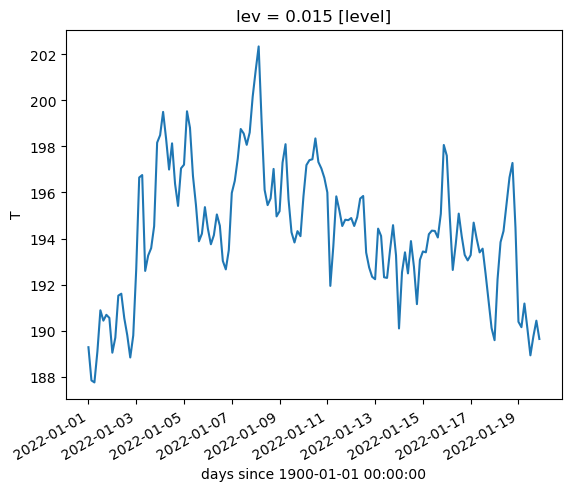

In [34]:
result.plot()

#### Optimization: Persisting data in worker memory

Sometimes you will need to compute multiple parameters on data from Dask objects. Using `.persist()` to store intermediate data in worker memory can save computational time if used appropriately. The raw data can be persisted too, of course, but watch out for exhausting worker memory.

Here we compare the time it takes - with and without persisting intermediate results - to compute our level-0 mean and a mean across all model levels.

We will also introduce another diagnostic tool here, the `MemorySampler` context manager.

In [35]:
from distributed.diagnostics import MemorySampler
ms = MemorySampler()

In [36]:
%%time
# Without persistance
with ms.sample("Original"):
    r1 = ds.T.isel(lev = 0).sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).compute()
    r2 = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lev","lat","lon"]).compute()

CPU times: user 915 ms, sys: 51.9 ms, total: 967 ms
Wall time: 22 s


In [37]:
%%time
# With persistance
with ms.sample("Persist"):
    T_means = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).persist()
    r1 = T_means.isel(lev = 0).compute()
    r2 = T_means.mean("lev").compute()

CPU times: user 571 ms, sys: 50.7 ms, total: 622 ms
Wall time: 15.2 s


Without persisting the intermediate results, Dask will only store r1 and r2 in worker memory, and so the indexing operations must be done from scratch each time.

Let's look at the memory usage...

<AxesSubplot: xlabel='time', ylabel='Cluster memory (GiB)'>

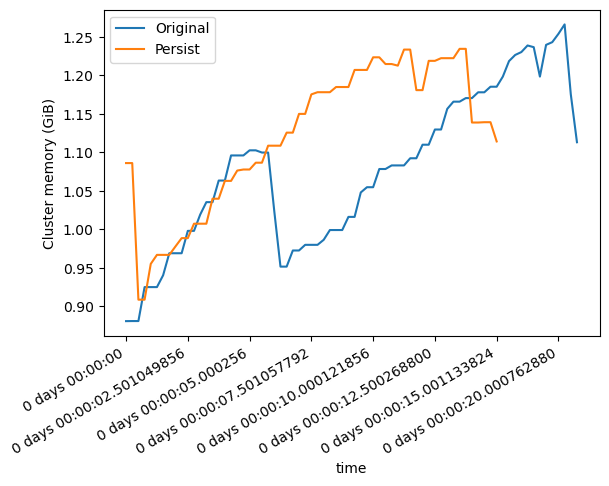

In [38]:
ms.plot(align=True)

Because the intermediate results are required for the second calculation in the original case, we do not even use more memory. A clear win!

Of course, when persisting data it is extra important to clean up. Running `del` on your persisted client variable will clear those data from worker memory (*as long as they are not referenced by other variables*).

In [39]:
del T_means

In [47]:
# Close current workers
cluster.scale(0)

### Debugging workers case study: memory and spill-to-disk

In this section, we will demonstrate two common considerations when using Dask on HPC:
* Dask data spilling to disk
* Interacting with `dask.distributed` worker logs

For this case study, we will generate progressively larger Dask arrays that eventually trigger memory conditions. Dask workers handle data in different ways in the following memory regimes:

|Default Threshold|Case Study Value|Worker Behavior|
|-|-|-|
|0.6 (managed mem)|1.2 GB|Data is allocated on disk (spill)|
|0.7 (process mem)|1.4 GB|Data is allocated on disk (spill)|
|0.8|1.6 GB|New data allocation is paused|
|0.95|1.9 GB|Worker is killed to avoid OOM|

These thresholds can be set at cluster creation time or overridden by your Dask Distributed configuration file.

In [52]:
import dask.array as da
from distributed.worker import logger

It is possible to write directly to worker logs (PBS job logs in our case) using the worker `logger` from Dask Distributed. Here, we define a function to call the logger on each worker, which we will run eagerly via `client.run`.

Keep an eye on the worker memory Dashboard panel as our for loop proceeds...

In [43]:
def log_message(chunk_size):
    logger.info("Current chunk size = {} MiB".format(chunk_size))

In [48]:
# Start up 4 new workers
cluster.scale(4)
client.wait_for_workers(4)

In [53]:
for chunk_mib in [800, 1200, 1600, 1950]:
    client.run(log_message, chunk_mib)
    chunk_size = chunk_mib / 8 * 1024 * 1024
    print("Mean of {} MiB random array = {:0.2f}".format(chunk_mib, da.random.random((chunk_size * 4), chunks=(chunk_size)).mean().compute()))

Mean of 800 MiB random array = 0.50
Mean of 1200 MiB random array = 0.50
Mean of 1600 MiB random array = 0.50


KilledWorker: Attempted to run task ('random_sample-mean_chunk-ae5310e72ae2fbccc811652cca67b189', 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://10.12.206.54:37929. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [60]:
# List the most recent 4 worker logs - these should be our logs
!ls -lrt dask-worker-logs | tail -n 4

-rw-r--r-- 1 vanderwb csgteam  6624 Jan 31 12:06 5499152.casper-pbs.OU
-rw-r--r-- 1 vanderwb csgteam  6624 Jan 31 12:06 5499154.casper-pbs.OU
-rw-r--r-- 1 vanderwb csgteam  6624 Jan 31 12:06 5499153.casper-pbs.OU
-rw-r--r-- 1 vanderwb csgteam  6624 Jan 31 12:06 5499155.casper-pbs.OU


We can open the log file in the Lab interface or a terminal and investigate the reason for the `KilledWorker` exception.

In [62]:
# Let's look at the worker state in PBS after the failure
!qstat -u vanderwb


casper-pbs: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
5497026.casper* vanderwb jhublog* cr-login-*   9762   1   1    4gb 720:0 R 03:31
5499152.casper* vanderwb htc      dask-work* 286479   1   1    2gb 00:30 R 00:14
5499153.casper* vanderwb htc      dask-work* 286536   1   1    2gb 00:30 R 00:14
5499154.casper* vanderwb htc      dask-work* 286593   1   1    2gb 00:30 R 00:14
5499155.casper* vanderwb htc      dask-work* 286653   1   1    2gb 00:30 R 00:14


Notice how the workers retried the final computation a few times before giving up. This behavior occurs when using the `nanny`, which attempts to restore workers when they are killed for various exceptions.

Recall the aforementined memory thresholds - workers get killed by Dask before exceeding the absolute limit of a job (which if hit on certain systems, could kill the PBS job too). Because of this safety mechanism, our PBS jobs are still intact.

If you are running a long computation that, *if restarted*, could exhaust the worker job's walltime, you can disable the nanny functionality and make exceptions fatal.

In [64]:
# Shut down our client (thus terminating workers)
client.shutdown()

## Analyzing your allocation

Dask does not provide integrated tools for analyzing the impact to your allocation (though you could back out values with care). This job is best suited for the scheduler itself, assuming that you've carefully instantiated your workers.

Consider this value from my Dask config:

In [65]:
config.get('jobqueue.pbs')['name']

'dask-worker'

This means that every Dask worker I start via a `PBSCluster` will have the job name **dask-worker**. We can leverage this along with our `qhist` utility to query the logs:

```bash
qhist -u $USER -n dask-worker -f numcpus,elapsed -c > qhist-dask.out
```

This command will query all dask-workers in today's scheduler logs and output to CSV, which we redirect to a file. The `name` field is a powerful tool. If instead you use a worker name specific to your script, you can easily query only the jobs from that script.

We can then read in the CSV using pandas (or even using a Dask Dataframe!).

In [1]:
import pandas as pd

In [5]:
dj = pd.read_csv("../data/qhist-dask.out")
dj.head()

,Job ID,NCPUs,Elapsed (h)
0,5499155.casper-pbs,1,0.40
1,5499153.casper-pbs,1,0.40
2,5499152.casper-pbs,1,0.40
3,5499154.casper-pbs,1,0.40
4,5498724.casper-pbs,1,0.26


In [10]:
print("Core-hours used by this notebook: {}".format(sum(dj['NCPUs'] * dj['Elapsed (h)'])))

Core-hours used by this notebook: 8.3


Records from `qhist` span the time that PBS was used on each system, so with a bit of forward-thinking prep work (picking descriptive worker names), you can easily trace back usage.